In [128]:
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [129]:
#### Preprocecing ###

In [130]:
Confirmed = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [131]:
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
confirmed = df

In [132]:
contries = confirmed.max() >= 1000
confirmed = confirmed.loc[:, contries]
confirmed = confirmed.cummax()

In [133]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
recovered = df.loc[:, contries]
recovered = recovered.cummax()


In [134]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
death = df.loc[:, contries]
death = death.cummax()

In [135]:
### Data Preparation ###

In [136]:
country = 'Japan'
S0 = confirmed[country].values
R0 = recovered[country].values
D0 = death[country].values
P = 12000_0000
iter=10000

In [137]:
S0

array([   2,    2,    2,    2,    4,    4,    7,    7,   11,   15,   20,
         20,   20,   22,   22,   22,   25,   25,   26,   26,   26,   28,
         28,   29,   43,   59,   66,   74,   84,   94,  105,  122,  147,
        159,  170,  189,  214,  228,  241,  256,  274,  293,  331,  360,
        420,  461,  502,  511,  581,  639,  639,  701,  773,  839,  839,
        878,  889,  924,  963, 1007, 1101, 1128, 1193, 1307, 1387, 1468,
       1693, 1866, 1866, 1953, 2178, 2495, 2617, 3139, 3139, 3654, 3906,
       4257, 4667, 5530])

In [138]:
data = {'T': S0.shape[0], 'P': P, 'S0': S0, 'R0': R0, 'D0': D0}

In [139]:
### Model ###

In [144]:
sm = pystan.StanModel(file="turzin.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_45b20564ad6c2e62cbbbc11b7f3ed615 NOW.


In [145]:
# Train the model and generate samples
fit = sm.sampling(data=data, iter=iter, init=0)

In [146]:
### Visualization functions ###

In [147]:
def sigmoid(x, theta, t0):
    return 1/(1 + np.exp(-theta*(x-t0)))

In [148]:
def simulate(init_inf, b0, b1, b2, theta_b, theta_b2, b_date, b2_date,
             q0, q1, q2, theta_q, theta_q2, q_date, q2_date, a, d, horizon):
    S = init_inf;
    R = 0;
    D = 0;
    S_list = [S]
    R_list = [R]
    D_list = [D]
    b_list = [b0]
    q_list = [q0]
    S0 = [q0 * S]
    R0 = [q0 * R]
    D0 = [D]
    for t in range(horizon):
        b = b0 + (b1-b0) * sigmoid(t, theta_b, b_date) + (b2-b1) * sigmoid(t, theta_b2, b2_date)
        I = (S - R - D) * b * (1 - S/P)
        q = q0 + (q1-q0) * sigmoid(t, theta_q, q_date) + (b2-q1) * sigmoid(t, theta_q2, q2_date)
        NR = a * (S - R - D)
        ND = d * (S - R - D)
        D = D + ND
        S = S + I
        R = R + NR
        S_list.append(S)
        R_list.append(R)
        D_list.append(D)
        b_list.append(b)
        q_list.append(q)
        S0.append(S0[-1]+q*I)
        R0.append(R0[-1]+a * (S0[-1] - R0[-1] - D0[-1]))
    data = pd.DataFrame({'S':np.array(S_list),
                        'R':np.array(R_list),
                        'D':np.array(D_list),
                        'b':np.array(b_list),
                        'q':np.array(q_list),
                        'S0':np.array(S0),
                        'R0':np.array(R0)},
                        index=pd.date_range(start=pd.to_datetime('2020-01-22'), periods=horizon+1, freq='D'))
    return data

In [150]:
def monte_carlo(fit, horizon):
    S = pd.DataFrame()
    R = pd.DataFrame()
    D = pd.DataFrame()
    b = pd.DataFrame()
    q = pd.DataFrame()
    S0 = pd.DataFrame()
    R0 = pd.DataFrame()
    I0 = pd.DataFrame()
    n = fit['init_inf'].shape[0]
    for i in range(n):
        df = simulate(init_inf=fit['init_inf'][i],
                      b0=fit['b0'][i],
                      b1=fit['b1'][i],
                      b2=fit['b2'][i],
                      theta_b=fit['theta_b'][i],
                      theta_b2=fit['theta_b2'][i],
                      b_date=fit['b_date'][i],
                      b2_date=fit['b2_date'][i],
                      q0=fit['q0'][i],
                      q1=fit['q1'][i],
                      q2=fit['q2'][i],
                      theta_q=fit['theta_q'][i],
                      theta_q2=fit['theta_q2'][i],
                      q_date=fit['q_date'][i],
                      q2_date=fit['q2_date'][i],
                      a=fit['a'][i],
                      d=fit['d'][i],
                      horizon=horizon)
        S = pd.concat([S, df['S']], axis=1)
        R = pd.concat([R, df['R']], axis=1)
        D = pd.concat([D, df['D']], axis=1)
        b = pd.concat([b, df['b']], axis=1)
        q = pd.concat([q, df['q']], axis=1)
        S0 = pd.concat([S0, df['S0']], axis=1)
        R0 = pd.concat([R0, df['R0']], axis=1)
        I0 = pd.concat([I0, df['S0'] - df['R0']], axis=1)
    return S, R, D, b, q, S0, R0, I0
    

In [151]:
def extract_series(fit, name):
    value_list = []
    for d in range(S0.shape[0]):
        vals = fit['{}[{}]'.format(name, d+1)]
        value_list.append(vals)
    data = np.array(value_list)
    return pd.DataFrame(data, 
                        index=confirmed.index)

In [152]:
def draw(simulated, real=None):
    graph=pd.DataFrame()
    simulated = simulated.dropna(axis=1)
    median = simulated.median(axis=1)
    upper = simulated.quantile(q=0.75, axis=1)
    lower = simulated.quantile(q=0.25, axis=1)
    if not real is None:
        graph['Real'] = real
    graph['Median'] = median
    graph['Upper'] = upper
    graph['Lower'] = lower
    sns.relplot(kind="line", data=graph, aspect=2)

In [153]:
S, R, D, b, q, S0, R0, I0 = monte_carlo(fit, 120)

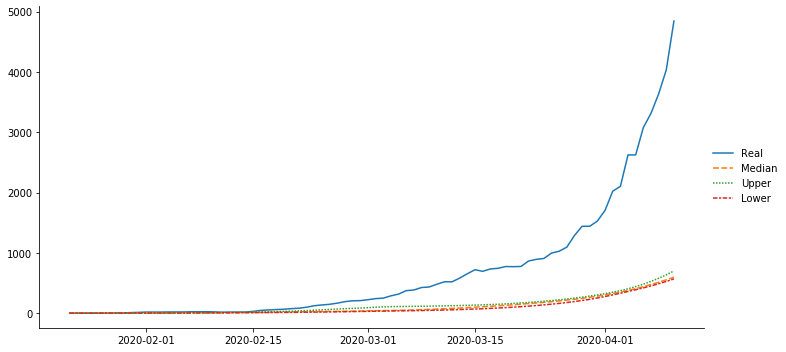

In [154]:
draw(I0, real=(confirmed-recovered)[country])

In [155]:
S.median(axis=1)[pd.to_datetime('2020-04-12')]

7096.540982350008

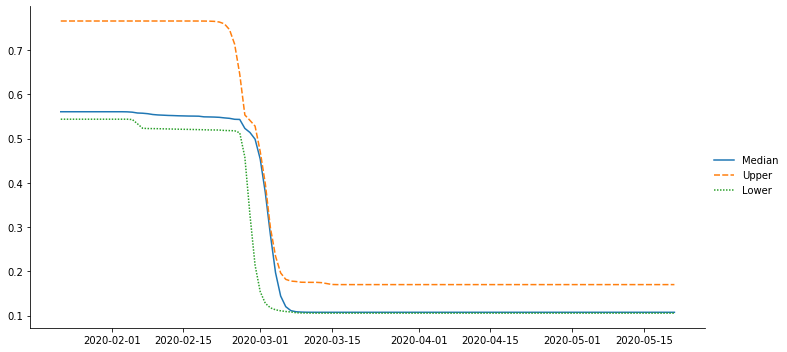

In [156]:
draw(q)

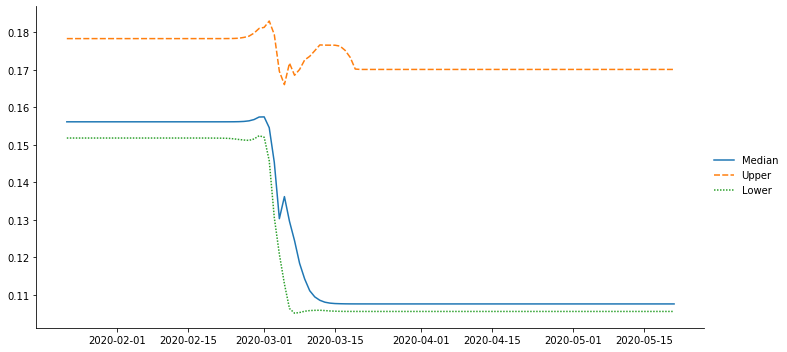

In [157]:
draw(b)

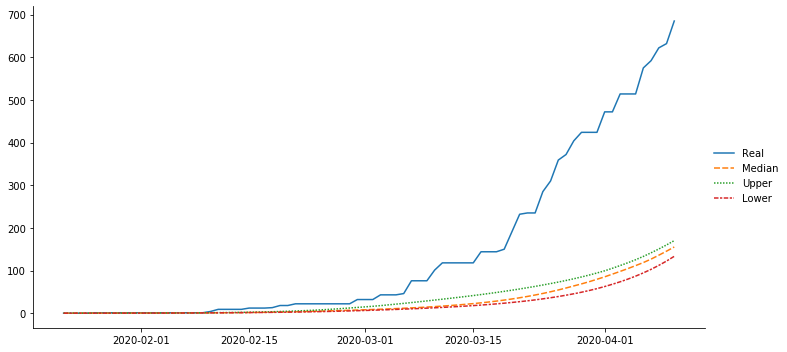

In [158]:
draw(R0, real=recovered[country])

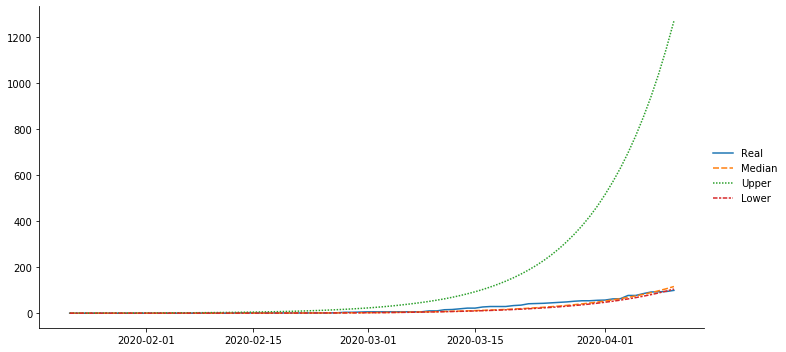

In [159]:
draw(D, real=death[country])

In [160]:
fit

Inference for Stan model: anon_model_45b20564ad6c2e62cbbbc11b7f3ed615.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf_alpha   0.99    0.03   0.08   0.87   0.94    1.0   1.02   1.06      7    1.3
init_inf_beta    1.01    0.03   0.06   0.92   0.97   1.02   1.03   1.11      3    1.9
init_inf         1.05    0.02    0.1   1.01   1.02   1.03   1.06   1.11     42   1.06
b0_alpha         0.91    0.08   0.14   0.51   0.89   0.93   1.02   1.03      3   3.74
b0_beta          1.02    0.02   0.03   0.96   1.01   1.03   1.04   1.09      3   1.77
b0               0.18    0.03   0.06   0.15   0.15   0.16   0.18    0.4      6   2.04
b1_alpha          1.1    0.07   0.13   0.98   0.99   1.05   1.19   1.39      4   1.63
b1_beta          1.25     0.3    0.7   0.92   0.97   0.99   1.03   3.12      5   1.99
b1               0.99    0.04   0.1

In [161]:
cumulative = pd.DataFrame(S.values, columns=range(len(S.columns)), index=pd.date_range(start=pd.to_datetime('2020-01-22'), periods=120+1, freq='D'))

In [162]:
predicted_recovered = pd.DataFrame(R.values, columns=range(len(R.columns)), index=pd.date_range(start=pd.to_datetime('2020-01-22'), periods=120+1, freq='D'))

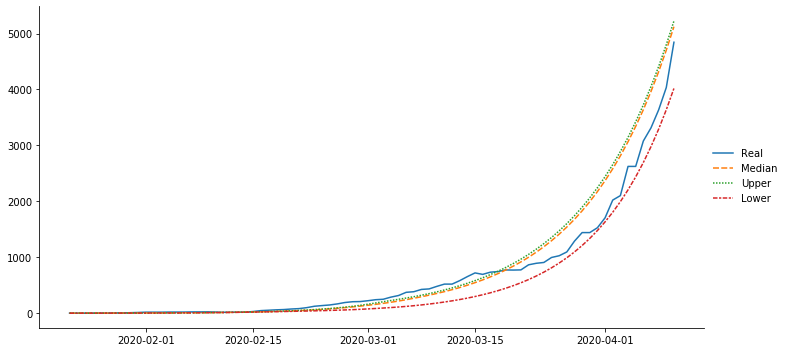

In [163]:
draw(cumulative - predicted_recovered, real=(confirmed-recovered)[country])

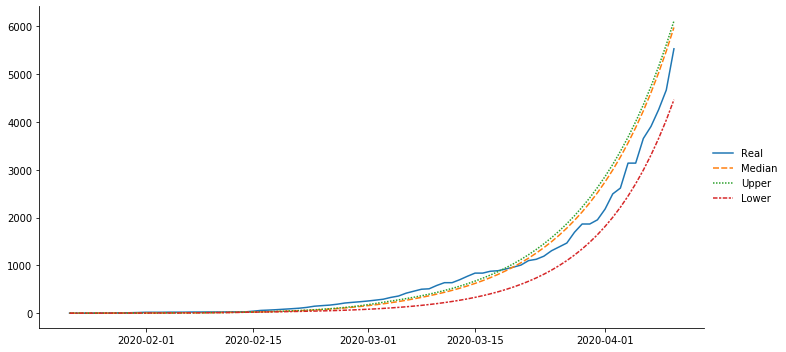

In [164]:
draw(cumulative, real=confirmed[country])

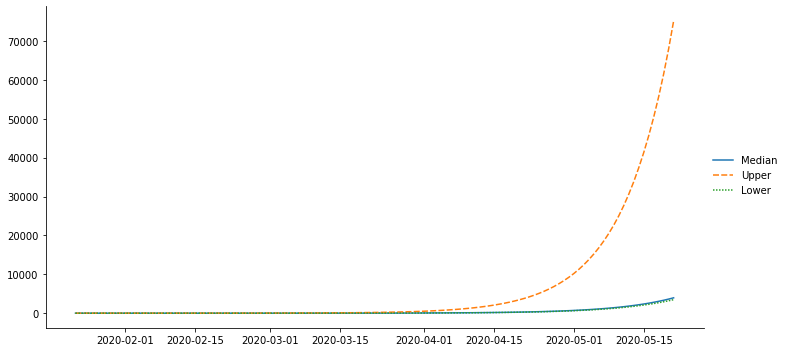

In [165]:
draw(D)